# Generate a List of Strong / Good Lines

## Contents
- [Get set up](#getsetup)
- [Step 1: Reduce the full line list](#step1)
- [Step 2: Further reduce the line list with Moog](#step2)
- [(Optional) Step 3: Further customize your line list](#step3)
- [(Optional) Compare line lists](#comparelinelists)


### Problem:   
We can easily and quickly generate a very detailed line list for a spectral region using linemake.  However, this line list is often more detailed than necessary, especially when doing a 'quick' abundance analysis.  For example, many lines in the full line list may not be significant or detectably present in our spectrum.

### Goal:  
Given a spectrum and a full line list, generate a list strong / good lines specifically curated for the given spectrum

### Challenges:
We could run the full line list through the moog loooper function to see if the line is a 3sigma detection, but this would take a very long time to do as the full line list may have tens of thousands of lines.  So first, we must develop a way of reducing the initial full line list.  Then we can test this list for detections. 


### Requirements:  
A continuum normalized and radial velocity corrected spectrum and a full line list. 

## ToDo:


**Identify Missing Lines**
- Write a function that will identify missing lines 
    - Sometimes we identify spectral features which have no corresponding lines in the master line list.  We want to identify these and save their wavelengths to a special file
    - For each peak, if no line in line list within window: save wavelength to file


**Lower Priority Things**  
These things would be useful, but not critical 
- Add functions to add back in all lines from a certain species into your line list
    - If the user knows they want all lines of a certain type, then there could be a cell at the beginning which extracts all those lines from the master list.  This could be instead of Step 1 where the master line list gets reduced.  The user could then have the option to run their line list of only that species through moog
    - Or could add a function at the very end which will add lines from a certain species from the master line list to the list that was produced at the end 
    - I'm thinking this may be useful if we want to look at uranium lines for example or just want to generate a list of only iron lines
- Add functions to remove all lines from a certain species into your line list
    - I'm thinking we may want an iron free list 
    - This would make the most sense to do at the very beginning 
    
___

# Get set up <a id='getsetup'></a>

In [108]:
import os
import sys
import shutil
from scipy.signal import find_peaks
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import numpy as np

from astropy.io import ascii
from astropy.table import Table

from scipy.signal import savgol_filter

# # A bunch of functions to interface with MOOG
# import moog_funcs as mf

# ----------------- Import the other files of functions
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import asap_lib.moog_funcs as mf
import asap_lib.spectra as sa
import asap_lib.auto_atmosphere as aa
import asap_lib.calc_abunds as calc_abunds
import asap_lib.line_list_utils as llu
from asap_lib.config import dataDir



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.interpolate import interp1d

%matplotlib notebook

**Read in the master/full line list**

In [109]:
# ll = np.array(open('../ll.3500.3999').readlines()[1:])
# ll = np.array(open('../ll.4000.4600').readlines()[1:])
ll = np.array(open('../ll.4600.4999').readlines()[1:]) # Change Me

# ----------
ll_waves = np.array([ float(item.split()[0]) for item in ll ])
ll_species = np.array([ float(item.split()[1]) for item in ll ])
ll_ep = np.array([ float(item.split()[2]) for item in ll ])
ll_lgf = np.array([ float(item.split()[3]) for item in ll ])
init_len = len(ll)

print('{} lines in the provided full line list'.format(init_len))

13343 lines in the provided full line list


**Read in your data**

In [110]:
# Define the star of interest
# This name must match the spectrum name (minus file extension) and will be used for naming later files
# name = 'HD122563' # Change Me
name = 'HD222925Blue' 

spec_path = '/arc5/home/jglover/Data/final_spectra/'

# Path to the full spectrum
spectrum = os.path.join(spec_path, name + '.xy')

# Model atmosphere parameters for your star of interest: [Temperature, logg, metallicity]
# params = [4749, 1.12, -2.89] # Change Me
# params_err = [89, 0.11, 0.1] # Change Me

params = [5636, 2.54, -1.5] # Change Me
params_err = [103, 0.17, 0.1] # Change Me

In [111]:
w, f = sa.read_spec(spath = spectrum , ftype='xy')

# ----------------  Restrict the input spectrum to the wavelength range covered by the full line list 
i = np.where( (np.array(w) >= min(ll_waves)) & (np.array(w) <= max(ll_waves) ))[0]
w = w[i]
f = f[i]

**Quick Look at the Full Line List**

In [36]:
# ---------------- Restrict the full line list to the region where we have spectral data 
i = np.where( (ll_waves >= min(w)) & (ll_waves <= max(w))   )[0]

ll = ll[i]
ll_waves = ll_waves[i]
ll_species = ll_species[i]
ll_ep = ll_ep[i]
ll_lgf = ll_lgf[i]

print('{} lines in the provided full line list fall in the spectral range'.format(len(ll)))
print('This will become the working full line list')

13341 lines in the provided full line list fall in the spectral range
This will become the working full line list


*Visualize*   
In the following plot, we draw a vertical line everywhere there is a line in the full (working) line list that falls within the spectral range.  This is to visualize the line list. 

You can see that many of the lines in the full line list fall on wavelengths without significant spectral data.  It is likley many of the lines in the full line list are not significanlty contributing to the observed spectrum.

<IPython.core.display.Javascript object>


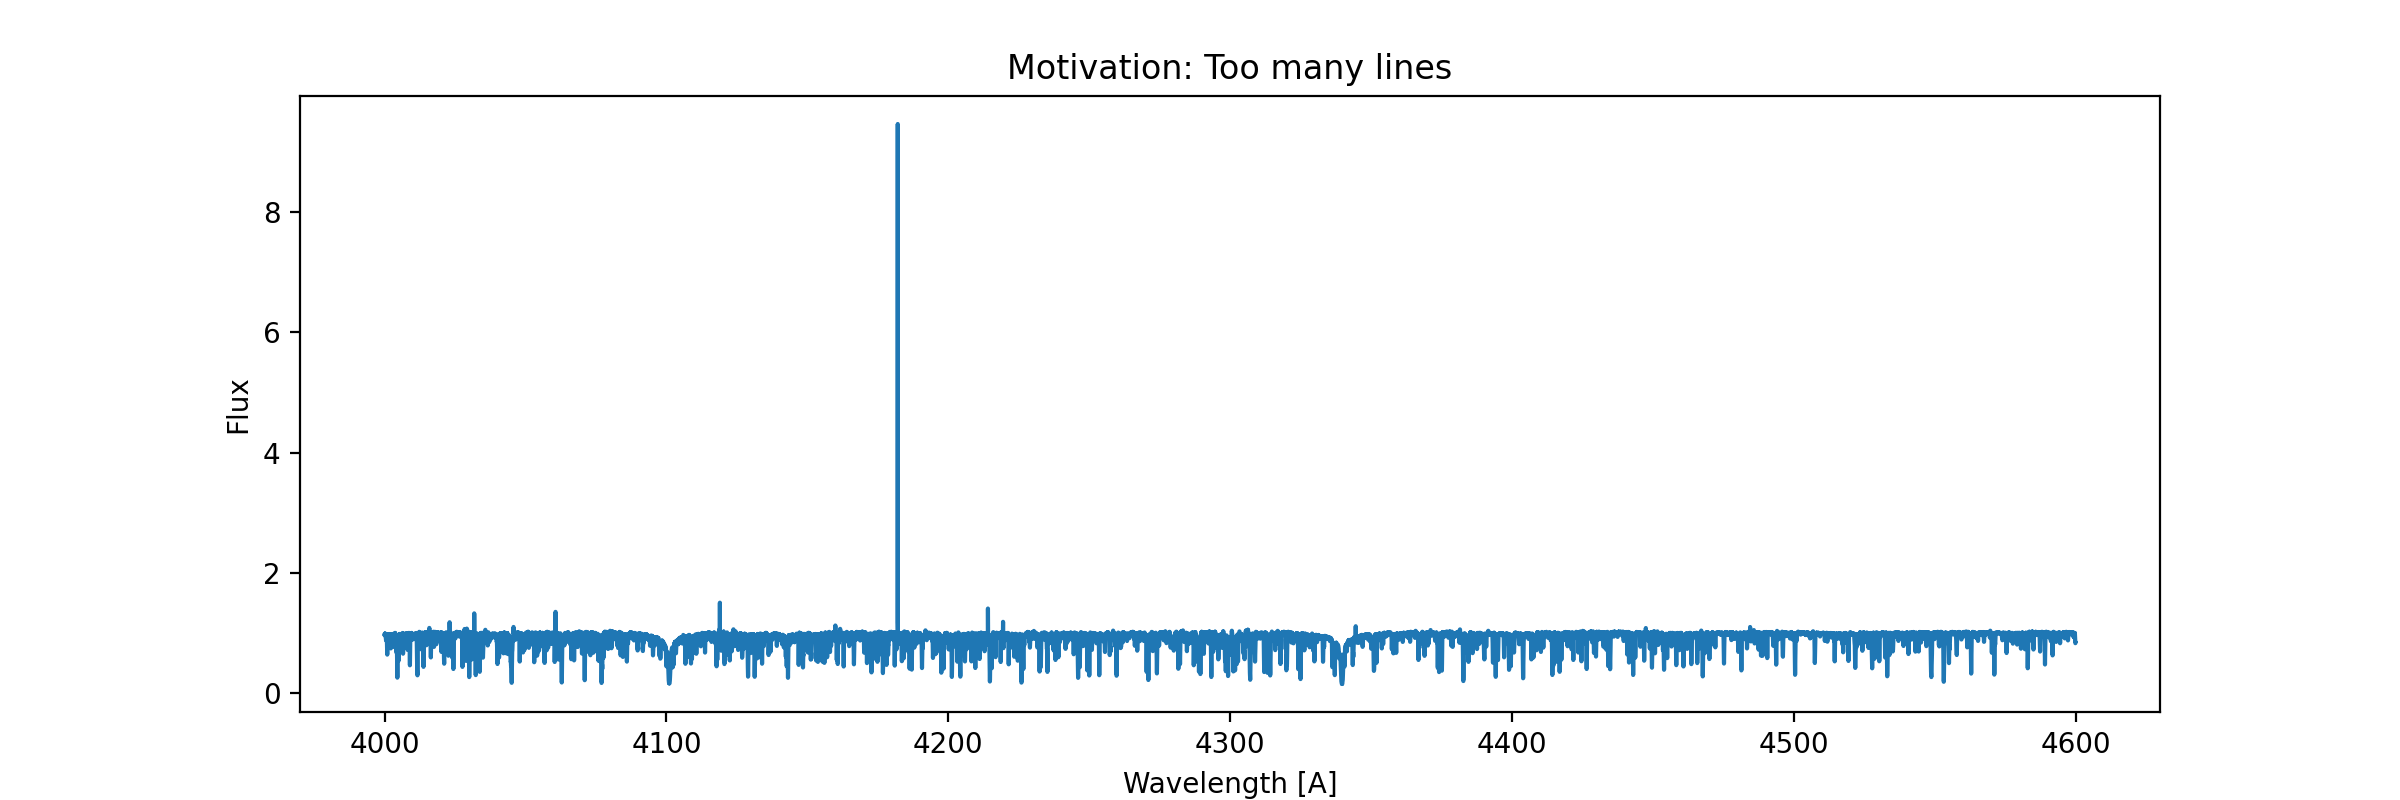

In [12]:
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
plt.title('Motivation: Too many lines')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f )

# ymin, ymax = ax.get_ylim()
# for ll_w in ll_waves:
#     plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=0 )

___

# Step 1: Reduce the full line list <a id='step1'></a>

We can begin to reduce the line list by identifying regions in the spectrum where there are lines. 
Any lines in the full line list which do not fall in one of these regions can be discarded.   

### Step 1.1: Identify Peaks

Spectral lines appear as peaks in the (invereted) flux data.  We can begin to identify regions of the spectrum where there are lines by identifing the locations of peaks in the data.  The scipy.signal functions `find_peaks` seems to do an excellent job of this. 

- minimumDepth is the minimum depth a spectral line can be (measured from 1) and still be idenified as a peak.  The minimum depth and help ensure that noise is not identified as a peak. 
    - A smaller minimum depth will allow for more peaks to be identified
    - A higher minimum depth will result in only strong lines being identified as peaks
    - If you do not want to restrict how deep a spectral line can be, you can set `minimumDepth=0`


- maximumDepth is the maximum depth a spectral line can be (measured from 1)  and still be idenified as a peak.
    - A smaller maxiumum depth will result in only weaker lines being identified
    - A higher minimum depth will result more lines being idenified.  
    - If you do not want to restrict how deep a spectral line can be, you can set `maximumDepth=None`



*Optional*  
Smooth the data, you can apply a smoothing function to remove some of the peaks from the data, then run the peak finding function.  You can use this as a way to choose the strenght of the peaks you wish to keep. 

- For example, a small smoothing filter will remove some of the noise and prevent it from being identified as peaks, but will leave most of the actual lines. 
- For example, a strong smoothing filter will remove most of the weak and mid-strength peaks, but will leave most of the strong lines. 
        
This another way you can fine tune your peak selection in addition to the parameters in find_peaks


In [44]:
minimumDepth = 0.05 # Change Me. A lower minimum depth will mean more peaks are identified
maximumDepth = None # Change Me. A small maximum depth will select only weak lines
prominence = 0.05 # Change Me. A lower prominince will mean more peaks are ientified  

In [45]:
# --------------- Optional Smooth the spectrum
# Comment this out or skip this section if you don't want to smooth

# order = 3           # Change Me
# window_length = 31   # Change Me
# f =  savgol_filter(f, window_length, order)

In [46]:
ind_minima = find_peaks(-f+1,height=(minimumDepth, maximumDepth), prominence=prominence )[0]
print('Found {} peaks '.format(len(ind_minima)))

Found 265 peaks 


<IPython.core.display.Javascript object>


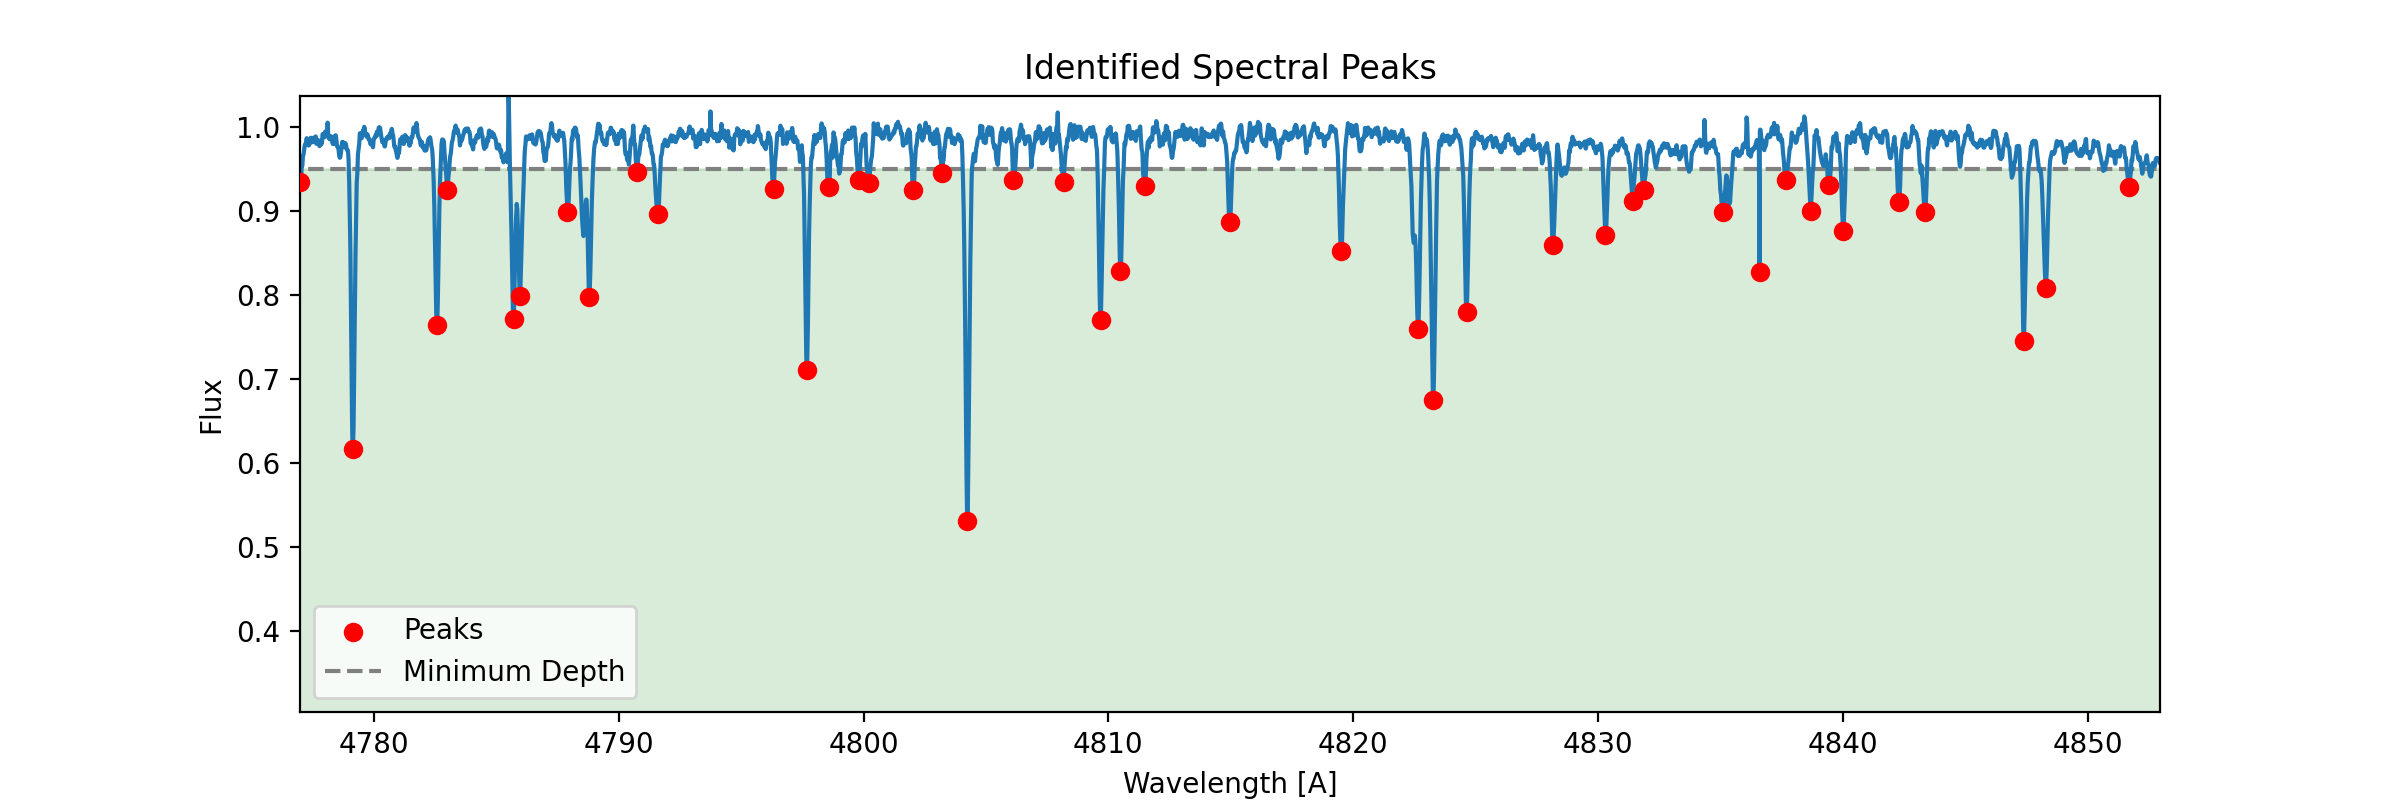

In [47]:
plt.figure(figsize=(12,4))

ax1  = plt.subplot(111)
plt.title('Identified Spectral Peaks')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.plot(w, f,zorder=2)

plt.scatter( w[ind_minima], f[ind_minima] , color='red', label='Peaks',zorder=3)


xmin, xmax = ax1.get_xlim()
if minimumDepth != None:
    plt.hlines( 1- minimumDepth, xmin, xmax, linestyle='--', zorder=1, color='grey', alpha=1, label='Minimum Depth' )
if maximumDepth != None:
    plt.hlines( 1- maximumDepth, xmin, xmax, linestyle='-.', zorder=1, color='grey', alpha=1, label='Maximum Depth' )

if minimumDepth != None and maximumDepth == None:
    rect = patches.Rectangle(( xmin , 0 ), xmax-xmin, 1-minimumDepth , linewidth=1, edgecolor='green', facecolor='green', alpha=0.15, zorder=0)
    ax1.add_patch(rect) 
    
if minimumDepth != None and maximumDepth != None:
    rect = patches.Rectangle(( xmin , 1-maximumDepth ), xmax-xmin, maximumDepth-minimumDepth , linewidth=1, edgecolor='green', facecolor='green', alpha=0.15, zorder=0)
    ax1.add_patch(rect)


plt.legend()

___
### Step 1.2:   Extract lines from full line list from specified regions


**Specify a search window**

Now that we have identified the peaks in the data and have a general sense of where there are spectral lines in the data, we must identify lines in the full line list which are near these locations. 

To do this we specify a window size.  Any lines in the full line list which fall within the specified window around the peak will be kept.   

- The code will keep lines from the full line list which fall within +/- the window size centered on each peak. Therefore, a good window size to start with is *half* the FWHM of a typical line in your spectrum.
- If you suspect your lines may have significant blending, you will want to select a larger window size. 
- If you suspect your lines are isolated, you can select a smaller window size. 



In [48]:
# ---------------  Specify the width in angstroms around the peaks within which you wish to extract lines 
window = 0.05 # Change Me.  A larger window will mean more lines are included in the reduced line list

<IPython.core.display.Javascript object>


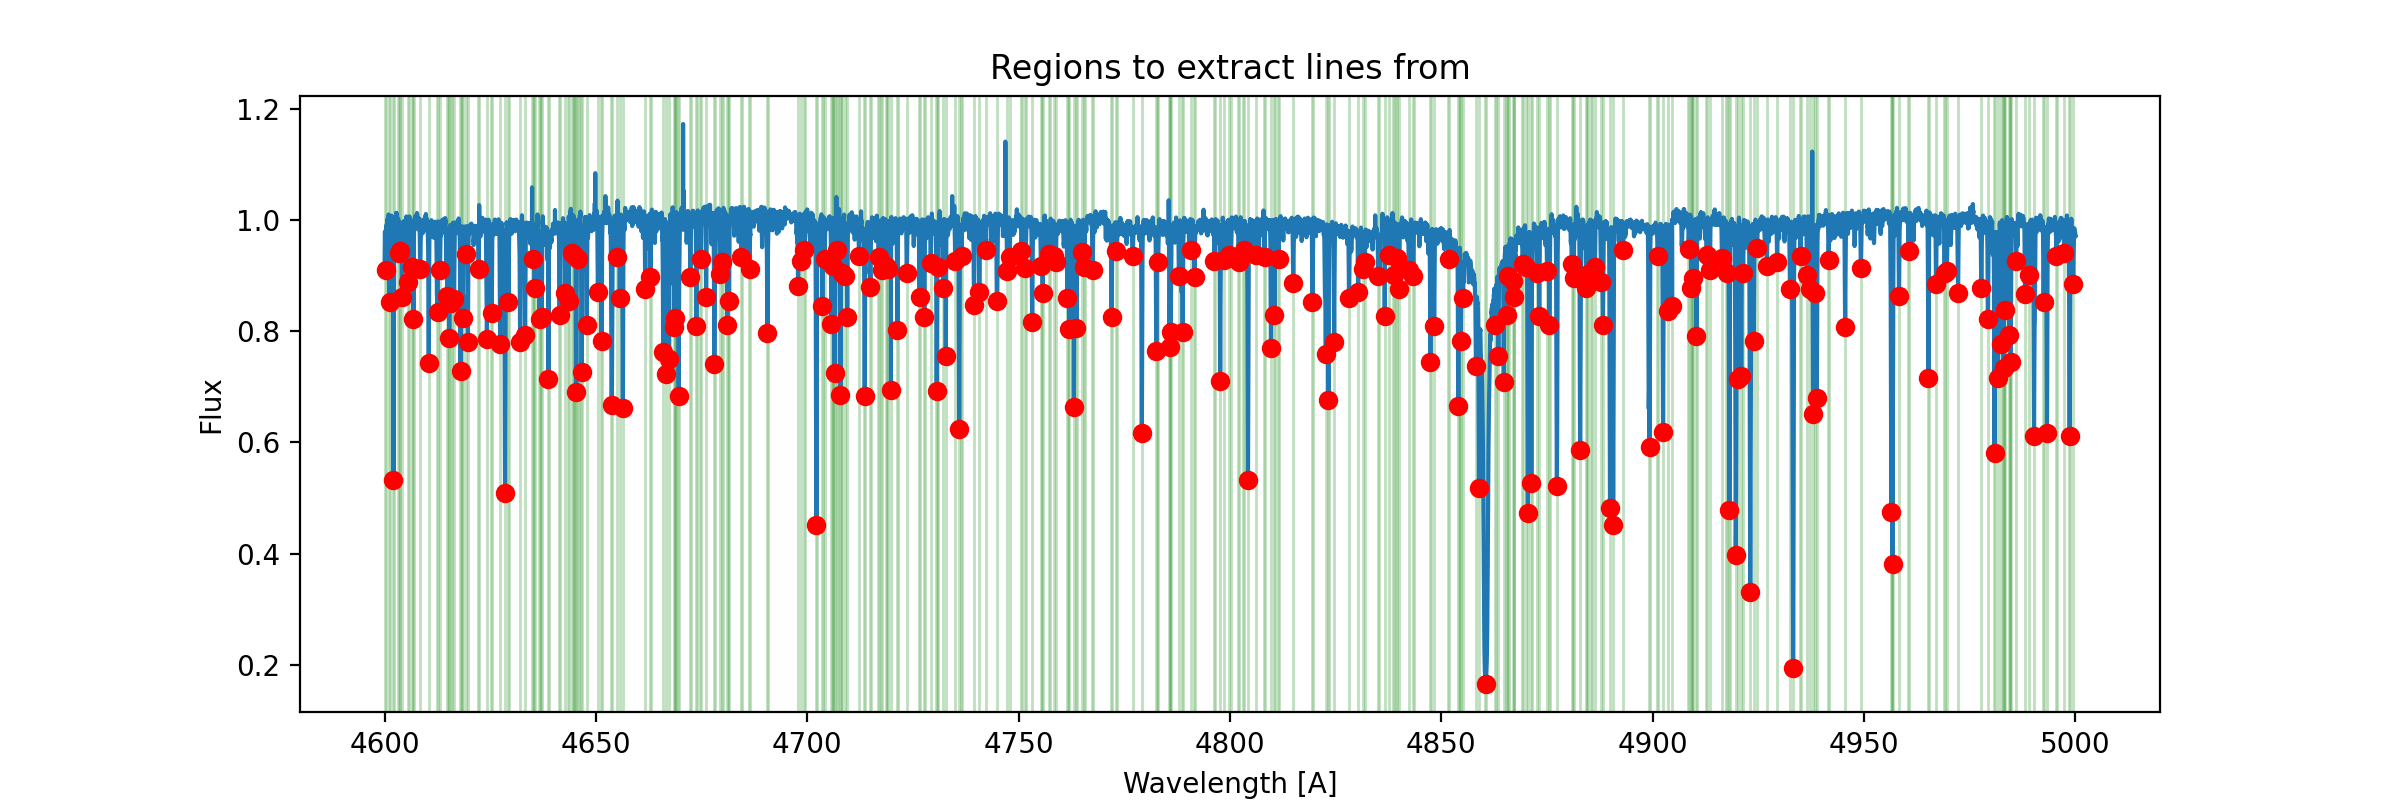

In [49]:
plt.figure(figsize=(12,4))

ax1  = plt.subplot(111)

plt.title('Regions to extract lines from')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w, f, zorder=1)

plt.scatter( w[ind_minima], f[ind_minima] , color='red', label='Peaks', zorder=2)


ymin, ymax = ax1.get_ylim()
for wi in w[ind_minima]:   
    rect = patches.Rectangle(( wi-window , ymin ), window*2, ymax, linewidth=1, edgecolor='green', facecolor='green', alpha=0.25, zorder=0)
    ax1.add_patch(rect)


Note:  Any lines from the full line list which fall wihin a green rectangle will be kept.  Everything else will be discarded.  
- Therefore, more green rectangles OR wider green rectangles  = potentially more lines in the final line list

**In each windowed region, extract lines from the large linelist**

("windowed region" = green rectangle in the above plot)

In [50]:
options = np.array([])
for ind in ind_minima:
    
    # Find all the lines in the line list within a window around this line 
    ll_ind = np.where( ( ll_waves >= w[ind] - window) & ( ll_waves <= w[ind] +window)    )[0]
    
    
    # If there are lines withinin the window
    if len(ll_ind) > 0:
        
        # Append to new line list 
        options = np.concatenate( ( options, ll[ll_ind])  )

**Collate those smaller linelists into one linelist**

In [51]:
options_waves = [ float(item.split()[0]) for item in options ]

options_dict = { options_waves[i]:options[i] for i in range(len(options)) }

reducedList = list(options_dict.values())

print('Found {} lines'.format(len(reducedList)))


Found 641 lines


**Visualize the Reduced List**  
Let's re-do the plot from above where a vertical line was plotted everywhere there is a line in the line list 

<IPython.core.display.Javascript object>


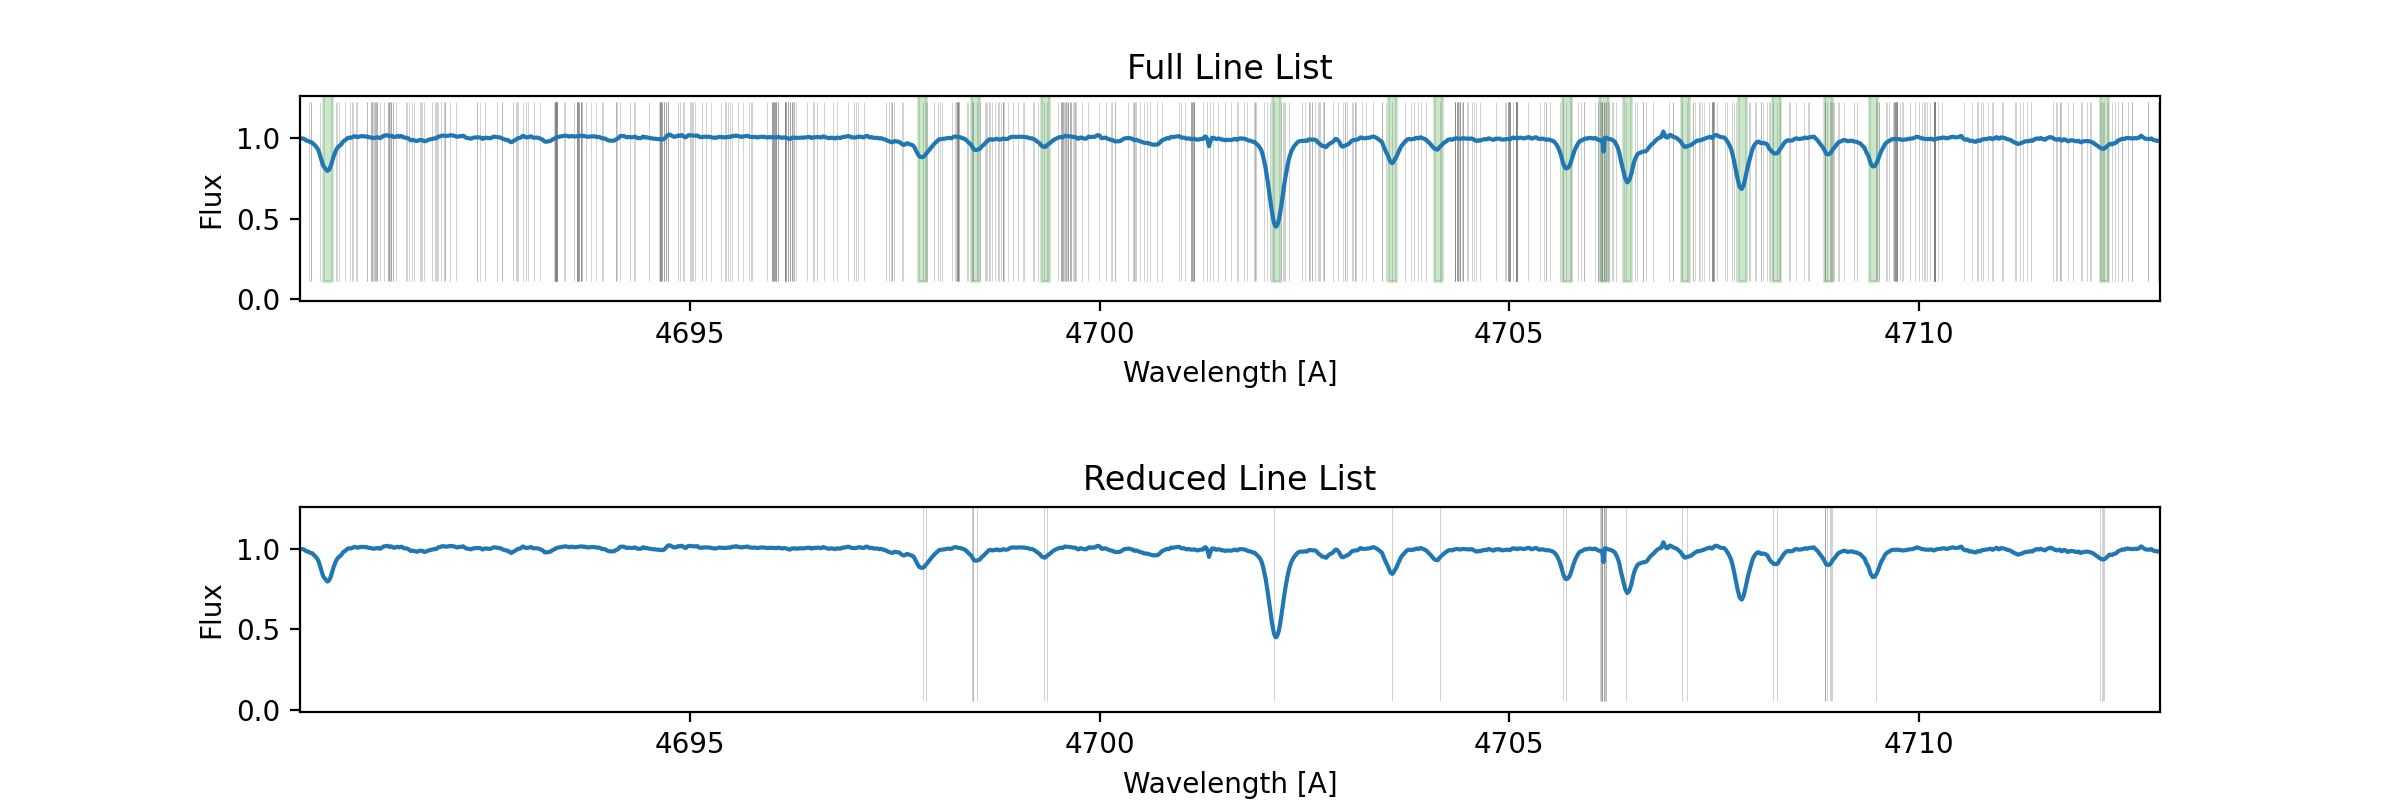

In [53]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(211)
plt.title('Full Line List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f )

ymin, ymax = ax1.get_ylim()
for ll_w in ll_waves:
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=1 )
    
for wi in w[ind_minima]:   
    rect = patches.Rectangle(( wi-window , ymin ), window*2, ymax, linewidth=1, edgecolor='green', facecolor='green', alpha=0.2, zorder=0)
    ax1.add_patch(rect)
    
# ---------------------------------------
ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.title('Reduced Line List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.plot(w, f)

ymin, ymax = ax1.get_ylim()
for ll_w in options_waves:
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=1 )


    
plt.subplots_adjust(hspace=1)


**Recap**

In [54]:
print('- {} lines in the provided full line list'.format(init_len))
print('- {} lines in the full line list within the spectral range'.format(len(ll)))
print('- {} lines in the reduced line list'.format(len(reducedList)))

- 13343 lines in the provided full line list
- 13341 lines in the full line list within the spectral range
- 641 lines in the reduced line list


**Save Reduced Line Lists**  
If you are happy with this, you can save the reduced line list

In [56]:
np.savetxt( '{}_reducedList.txt'.format(name),[ line.strip('\n') for line in reducedList ],  fmt='%s' )

print('Saving reduced list to '+os.getcwd()+'/{}_reducedList.txt'.format(name)  )

Saving reduced list to /arc5/home/jglover/ASAP/HD222925Blue_reducedList.txt


(Note: you do not have to do the next step, if you are happy with the line list found in step 1 you can stop here)

___

# Step 2: Further reduce the line list with Moog <a id='step2'></a>

We can now use moog on the reduced line list in order to identify which lines make a significant contribution to the observed spectrum.  This will reduce the reduced line list even further. 


### Step 2.1: Generate a model atmosphere

In order to run moog on the spectrum, we need to generate a model atmosphere.  Other than influencing the synthetic spectra generated by moog, this doesn't have any influence on the final reduced line list 

In [60]:
# Paths to places

# Where we are now and want to work
working_path = os.getcwd() + '/'

# Path to the spectra
spec_path = dataDir+'/final_spectra/'

# Path to send the MOOG output files
synth_out_path = os.path.join( dataDir , 'synthetic/')

In [61]:
# Define the model atmosphere name
model_in = name + '.mmod'

# Generate a MARCS model atmosphere and place it in the current working directory

aa.gen_mod_atm(name, params, working_path, print_params=True)

-----------------------------------------------------------------
----------------- Generating a Model Atmosphere -----------------
-----------------------------------------------------------------

----------------- Finding model atmosphere parameters:
-The model atmosphere parameters are: 
['5636 2.54 -1.5 1.83 HD222925Blue']
-Saving model atmosphere parameters to: params.txt 
-Saving atoms to: atoms.txt


----------------- Finding which group of model atmosphere grids to use based on the log g coverage:
-/arc5/home/jglover/ASAP/asap_lib/data/grids/standard/sphere/


----------------- Creating the model atmospheres:
-Reading params.txt
-Grid coverage for models in /arc5/home/jglover/ASAP/asap_lib/data/grids/standard/sphere/:
Temperature range: 3800.0 K - 7500.0 K
Gravity range: 0.0 - 3.5
Metallicity range: -5.0 - 1.0
(Though your stellar parameters may be within the grid boundaries, local gaps may cause problems. Tread carefully.)

------- Starting Model Atmosphere Creation for Star 

gv: Unable to open the display.


### Step 2.2: Run moog on the reduced line list 

The moog looper function will identify lines which are upper limits and remove them from the line list.  This will further reduce the list to only lines which make a significant contribution to the observed spectrum.  

In [62]:
# Path to the linelists
full_list_path = working_path 
print(full_list_path)

line_list = name+'_reducedList.txt' 
# line_list = name+'_reducedSmoothedList.txt' 
print(line_list)

# Create a dictionary for the linelist
line_dict = mf.lines_2_dict(line_list, params)

/arc5/home/jglover/ASAP/
HD222925Blue_reducedList.txt


In [197]:
test_abunds[1] - test_abunds[0] 

0.42105263157894735

In [63]:
# ----- Threshold
# The minimum of a generated synthetic spectrum for the given line must be within (threshold*100) percent
# of the corresponding location in the observed spectrum to be kept
threshold = 0.3 # Change me

# ----- Smoothing factors for the Gaussian smoothing kernel in angstroms
# Start with some first guess smoothing parameter for MOOG. This can be refined later.
smogs = [0.15] # Change me 

# ----- Test abdundances
# Generate an array of test abundances to get a quick metallicity estimate
# Note:  Choose a large range of test abundances (large difference in test abundance values is A-okay)
test_abunds = np.linspace(-4.0, 4.0, 20) # Change me 


# ----- Folder to save moog plots to
# Unlike the typical versions of moog_looper, all plots will be saved and not displayed in the notebook
folder = name+'_findlines_plots'

# If the subfolder does not exist, make it
exists = os.path.isdir(folder)
if not exists:
    os.mkdir(folder)

# ----- kwargs for findlines_mooglooper
kwargs = {  
'spec_name':name, 
'spectrum':spectrum, 
'model_atm':model_in,
'threshold': threshold,
'smogs': smogs, 
'abundances': test_abunds,
'retrim':True,
'trim_sigma':[5.0, 1.2],
'ul_sigma':3.0,
'correct_rv':False,              
'print_prog':False, 
'plots':True, 
'savefolder':'/arc5/home/jglover/ASAP/'+folder}

**Run findlines_mooglooper with multiprocessing**

In [64]:
st = time.time()
rslt = mf.findlines_multiprocess_driver(line_dict, kwargs)
en = time.time()

print('Total time {:.3f} seconds'.format(en - st))

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
/arc5/home/jglover/ASAP/asap_lib/moog_funcs.py:651: RuntimeWarning: divide by zero encountered in true_divide
  r_mean = np.nansum(((ssflux - (ioflux / cont_flux_mean)) ** 2) / ssflux)
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
/arc5/home/jglover/ASAP/asap_lib/moog_funcs.py:651: RuntimeWarning: divide by zero enc

/arc5/home/jglover/ASAP/asap_lib/moog_funcs.py:651: RuntimeWarning: divide by zero encountered in true_divide
  r_mean = np.nansum(((ssflux - (ioflux / cont_flux_mean)) ** 2) / ssflux)
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
/arc5/home/jglover/ASAP/asap_lib/moog_funcs.py:651: RuntimeWarning: divide by zero encountered in true_divide
  r

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

Total time 131.401 seconds


**Visualize the Moog Reduced List**  
Let's re-do the plot from above where a vertical line was plotted everywhere there is a line in the line list 

<IPython.core.display.Javascript object>


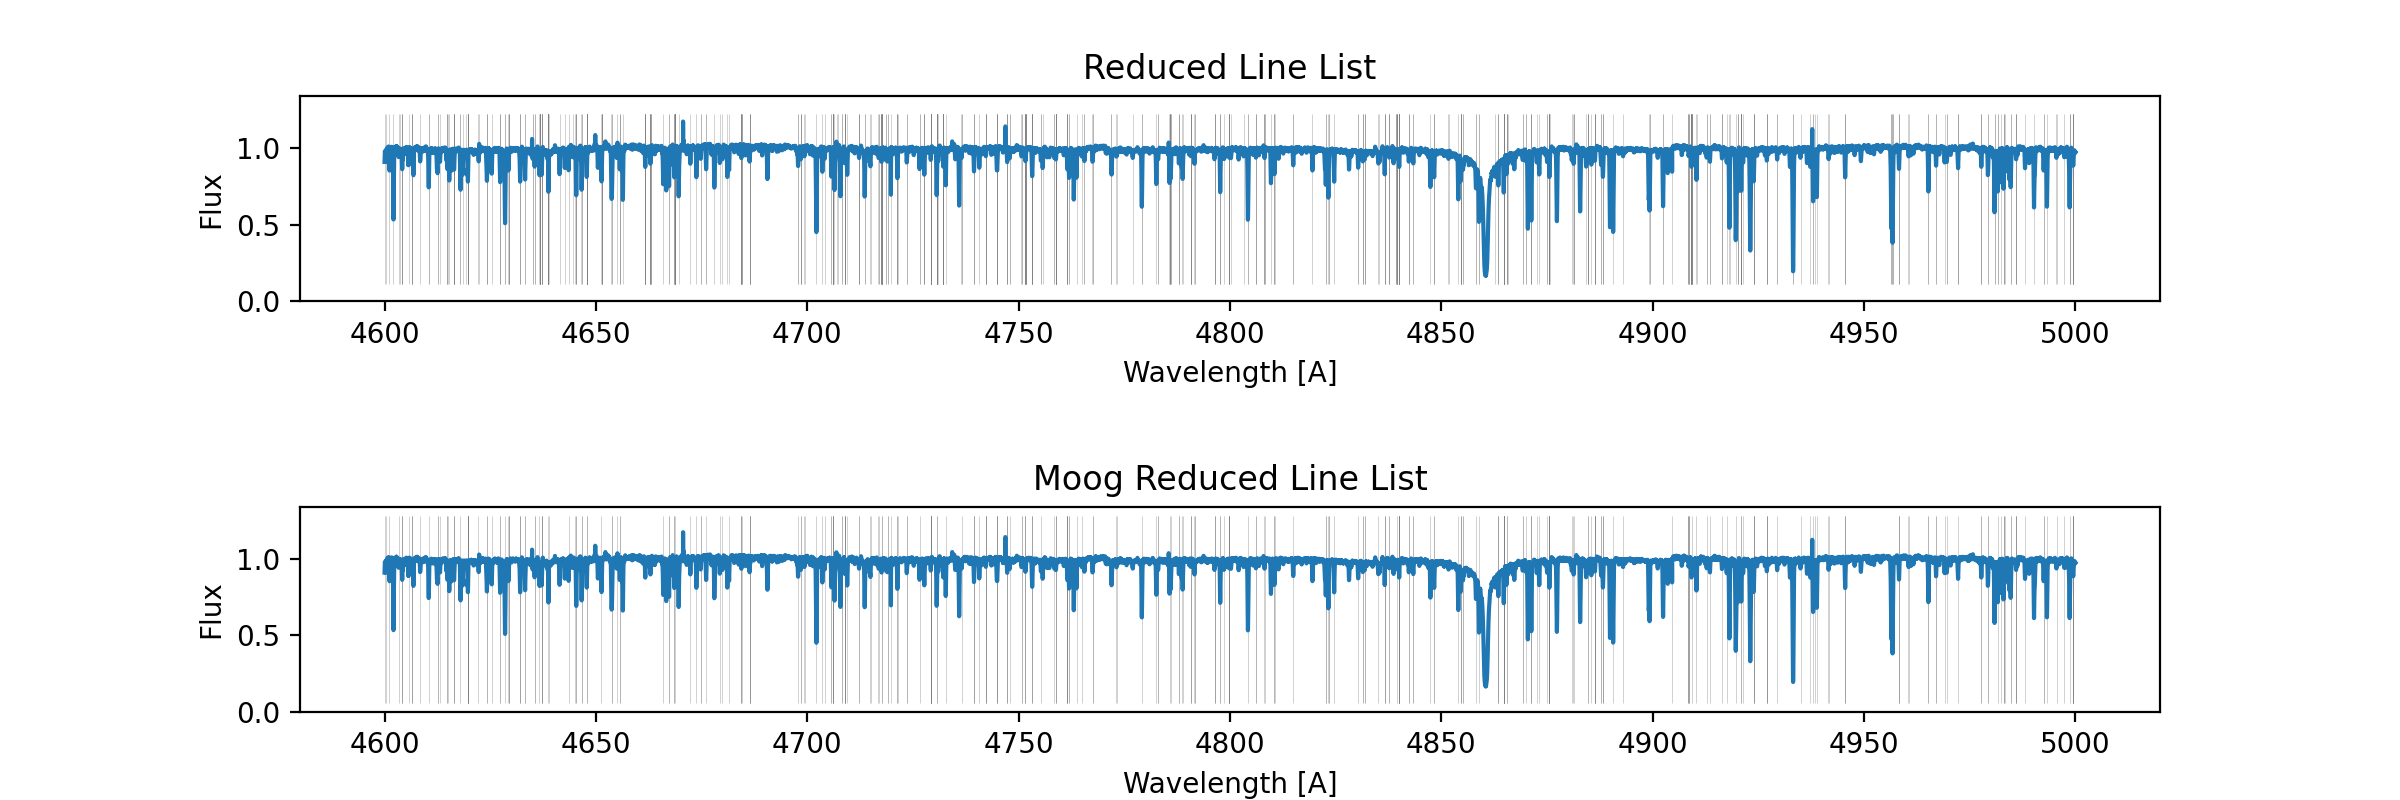

In [65]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(211)
plt.title('Reduced Line List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f )

ymin, ymax = ax1.get_ylim()
for ll_w in options_waves:
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=1 )

    
# ---------------------------------------
ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.title('Moog Reduced Line List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.plot(w, f)

ymin, ymax = ax1.get_ylim()
for ll_w in list(rslt.keys()):
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=1 )


    
plt.subplots_adjust(hspace=1)


**Recap**

In [66]:
print('- {} lines in the provided full line list'.format(init_len))
print('- {} lines in the full line list within the spectral range'.format(len(ll)))
print('- {} lines in the reduced line list'.format(len(reducedList)))
print('- {} lines in the moog reduced line list'.format(len(rslt.keys())))

- 13343 lines in the provided full line list
- 13341 lines in the full line list within the spectral range
- 641 lines in the reduced line list
- 405 lines in the moog reduced line list


**Save Reduced Line Lists**  
If you are happy with this, you can save the reduced line list

In [67]:
llu.dict_2_linelist(rslt,name+'_moogReducedList.txt' )

print('Saving reduced list to '+os.getcwd()+'/{}_moogReducedList.txt'.format(name)  )

Saving reduced list to /arc5/home/jglover/ASAP/HD222925Blue_moogReducedList.txt


---
# (Optional)  Step 3: Further Customize Your List <a id='step3'></a>

If you want you can further customize the line list you generated.

- I would recommend reviewing the plots produced by moog and manually removing lines which you do not like. 

### Remove lines by wavelength 
Remove specific lines from your line list using their wavelength

### Remove lines by species
Remove all lines from your list which correspond to a specific species

### Add lines by species
Add back all lines from the master line list which correspond to a specific species

___
# (Optional) Compare Line Lists <a id='comparelinelists'></a>

You may wish to compare the line list you just generated with another line list

In [157]:
i

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143])

In [177]:
# ----------------  Read in your line list
ll_path = name+'_moogReducedList.txt'
ll_w,ll_species, ll_ep, ll_lgf =  llu.read_linelist(ll_path)


# ----------------  Read in the line list(s) you wish to compare with 
compare_path = 'asap_lib/data/linelists/isolated_other_lists/linelist_noFe_xm.txt'
ll_compare_w, ll_compare_species, ll_compare_ep, ll_compare_lgf =  llu.read_linelist(ll_compare_path)


# ----------------  Restrict the comparision list to the spectral range of your list
i = np.where( (ll_compare_w >= min(ll_w)) & (ll_compare_w <= max(ll_w))   )[0]

ll_compare_w = ll_compare_w[i]
ll_compare_species = ll_compare_species[i]
ll_compare_ep = ll_compare_ep[i]
ll_compare_lgf = ll_compare_lgf[i]

In [181]:
ll_w

array([4600.206, 4600.267, 4601.156, 4603.343, 4604.17 , 4604.174,
       4604.226, 4605.674, 4606.502, 4606.51 , 4606.576, 4608.398,
       4610.48 , 4612.539, 4612.564, 4613.099, 4614.845, 4614.888,
       4614.911, 4616.463, 4616.473, 4616.49 , 4617.961, 4619.735,
       4619.758, 4619.764, 4619.769, 4619.77 , 4619.773, 4619.774,
       4619.777, 4619.778, 4622.228, 4624.217, 4624.232, 4625.381,
       4627.383, 4627.388, 4628.461, 4629.279, 4629.332, 4629.338,
       4629.358, 4632.052, 4632.082, 4632.088, 4633.216, 4633.255,
       4635.545, 4635.55 , 4636.646, 4637.173, 4637.179, 4637.192,
       4637.197, 4638.755, 4638.803, 4643.52 , 4644.963, 4645.31 ,
       4645.344, 4646.597, 4646.651, 4647.812, 4647.868, 4651.291,
       4653.729, 4653.75 , 4654.99 , 4655.648, 4655.685, 4665.906,
       4667.3  , 4667.363, 4668.557, 4668.559, 4668.598, 4672.295,
       4673.779, 4674.751, 4674.78 , 4676.087, 4679.323, 4679.891,
       4681.473, 4684.415, 4684.432, 4684.437, 4684.456, 4686.

In [191]:
# ----------------  Restrict the comparision list to the spectral range of your list
i = np.where( (ll_species == 26.0) )[0]
j = np.where( (ll_species == 26.1) )[0]

i = np.concatenate( (i,j) )

ll_w = ll_w[i]
ll_species = ll_species[i]
ll_ep = ll_ep[i]
ll_lgf = ll_lgf[i]

In [192]:
print('- {} line in the list'.format(len(ll_w)))
print('- {} line in the comparison list over the same spectral region'.format(len(ll_compare_w)))

- 68 line in the list
- 144 line in the comparison list over the same spectral region


In [193]:
inCompare_notMine = []
for wi in ll_compare_w:
    if wi not in ll_w:
        inCompare_notMine.append(wi)

        
inMine_notCompare = []
for wi in ll_w:
    if wi not in ll_compare_w:
        inMine_notCompare.append(wi)
        
        
inBoth = []
for wi in ll_w:
    if wi in ll_compare_w:
        inBoth.append(wi)


**Visualize the Lists Side By Side**  
Let's re-do the plot from above where a vertical line was plotted everywhere there is a line in the line list 

<IPython.core.display.Javascript object>


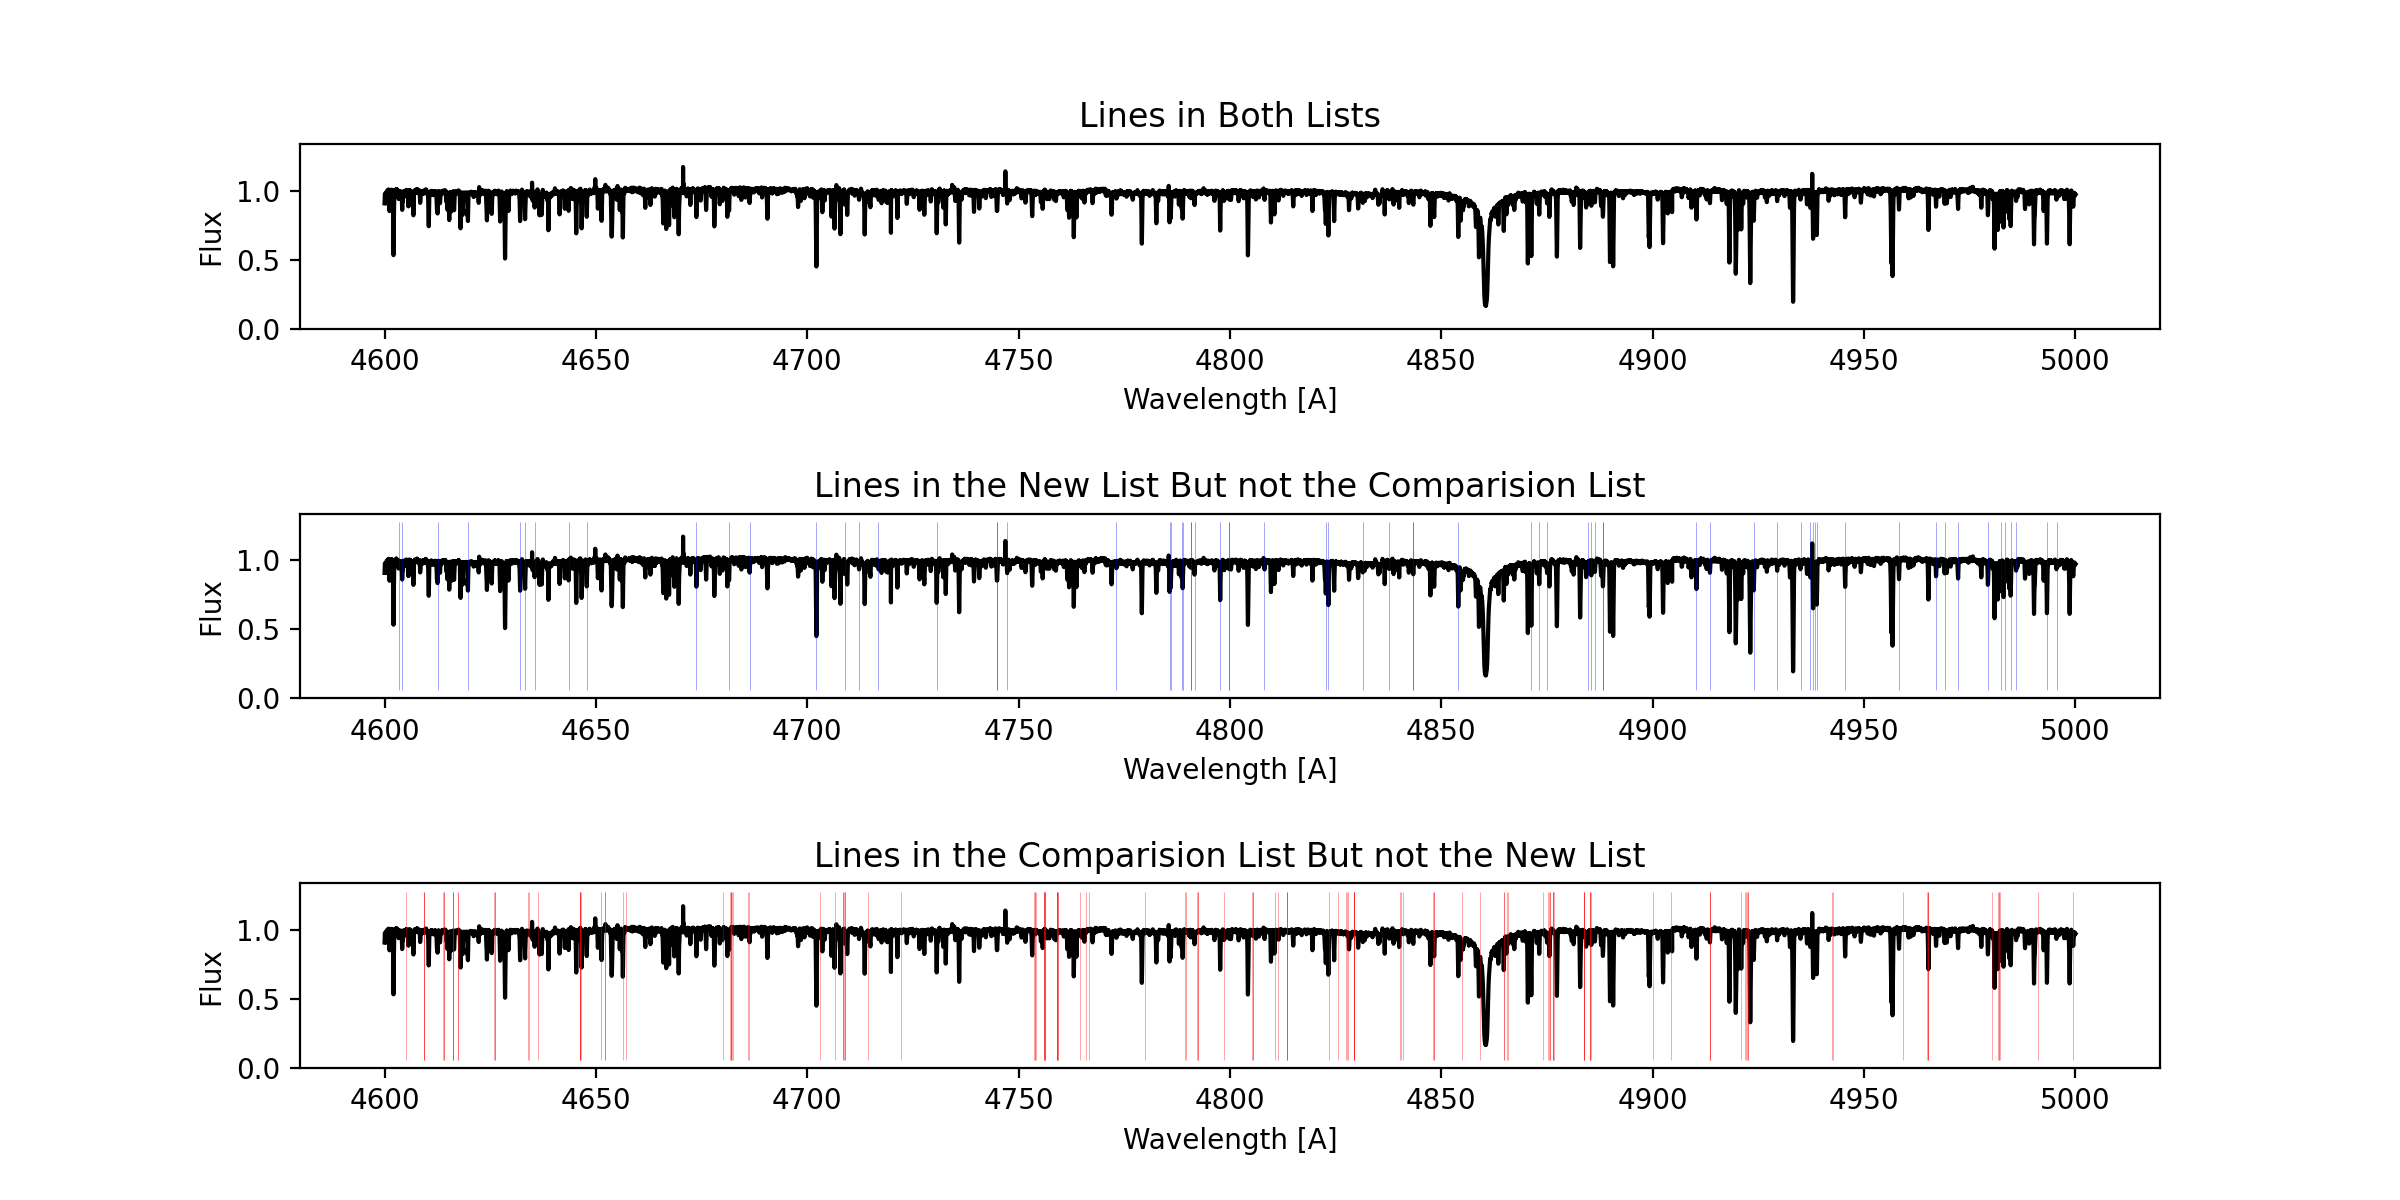

In [194]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(311)
plt.title('Lines in Both Lists')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f , color='k')
    
for wi in inBoth:
    plt.vlines( wi, ymin, ymax, color='green', linewidth=0.25, alpha=0.5, zorder=2 )

    
# ---------------------------------------
ax2 = plt.subplot(312, sharex=ax1, sharey=ax1)
plt.title('Lines in the New List But not the Comparision List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.plot(w, f, color='k')

for wi in inMine_notCompare:
    plt.vlines( wi, ymin, ymax, color='blue', linewidth=0.25, alpha=0.5, zorder=2 )
    

# ---------------------------------------
ax1 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.title('Lines in the Comparision List But not the New List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f, color='k' )

    
for wi in inCompare_notMine:
    plt.vlines( wi, ymin, ymax, color='red', linewidth=0.25, alpha=0.5, zorder=2 )
    
    
plt.subplots_adjust(hspace=1)

# plt.figlegend(lines, labels, loc = 'lower center', ncol=5, labelspacing=0.)
